In [126]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
from IPython.display import display, HTML

# **Predicting movie revenue using linear regression**

Let's first see how some basic variables correlate with revenue, specifically:
- budget
- is_en: whether the movie is in english
- popularity
- runtime

In [127]:
movie_revenues = pd.read_csv('movie_revenues.csv')

data = movie_revenues[['title', 'budget', 'runtime', 'popularity', 'revenue']]
data['is_en'] = movie_revenues['original_language'].apply(lambda x: 1 if x == 'en' else 0)
data.dropna(inplace=True)

Xcols = data.columns.difference(['revenue', 'title'])
X = data.loc[:, Xcols]
y = data['revenue']

data

,title,budget,runtime,popularity,revenue,is_en
0,Hot Tub Time Machine 2,14000000,93.0,6.575393,12314651,1
1,The Princess Diaries 2: Royal Engagement,40000000,113.0,8.248895,95149435,1
2,Whiplash,3300000,105.0,64.299990,13092000,1
3,Kahaani,1200000,122.0,3.174936,16000000,0
4,Marine Boy,0,118.0,1.148070,3923970,0
...,...,...,...,...,...,...
2995,Chasers,0,102.0,9.853270,1596687,1
2996,We Are the Best!,0,102.0,3.727996,180590,0
2997,The Long Kiss Goodnight,65000000,120.0,14.482345,89456761,1
2998,Along Came Polly,42000000,90.0,15.725542,171963386,1


In [128]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

Correlation coefficients:
budget: 0.7529244561869333
is_en: 0.14163124487140186
popularity: 0.4613468767475681
runtime: 0.2163801301814721


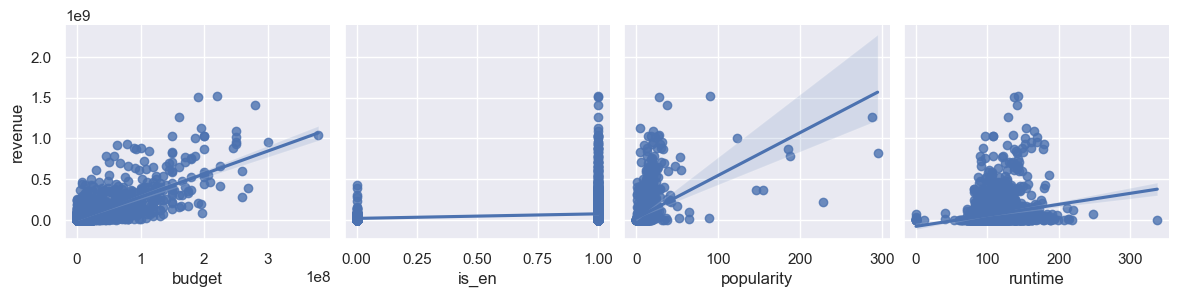

In [129]:
print('Correlation coefficients:')
for x in X:
    print(f'{x}: {y.corr(X[x])}')

sns.pairplot(data, x_vars=X.columns, y_vars=['revenue'], height=3, kind='reg');

It seems that budget is the explanatory variable most strongly associated with the revenue, since it has the highest correlation coefficient and we can see a trend in the scatter plot.<br>
is_en doesn't seem to be a good predictor of revenue, and the other two variables are somewhere in between.

Let's construct some new features that could be useful and fit a multiple linear regression model.  Specifically, we will add:
- has_actor: 1 if the movie casts one or more of a handful of popular actors, 0 otherwise
- has_director: 1 if one or more of a handful of popular directors are involved, 0 otherwise
- female_pct: the percentage of female actresses in the cast

In [130]:
actors = ['Christian Bale', 'Tom Hardy', 'Cilian Murphy', 'Scarlett Johansson', 'Johnny Depp', 'Will Smith', 'Ryan Gosling']
has_actor = movie_revenues['cast'].str.contains('|'.join(actors))
data['has_actor'] = has_actor[data.index].astype(float)

directors = ['Christopher Nolan', 'Martin Scorcese', 'Steven Spielberg', 'Quentin Tarantino']
has_director = movie_revenues['crew'].str.contains('|'.join(directors))
data['has_director'] = has_director[data.index].astype(float)

females = movie_revenues['cast'].str.count(f"'gender': 1")
males = movie_revenues['cast'].str.count(f"'gender': 2")
female_pct = females / (females + males)
data['female_pct'] = female_pct[data.index]

data.dropna(inplace=True)
data = data.astype({'has_actor': int, 'has_director': int})

Xcols = data.columns.difference(['revenue', 'title'])
X = data.loc[:, Xcols]
y = data['revenue']

data

,title,budget,runtime,popularity,revenue,is_en,has_actor,has_director,female_pct
0,Hot Tub Time Machine 2,14000000,93.0,6.575393,12314651,1,0,0,0.444444
1,The Princess Diaries 2: Royal Engagement,40000000,113.0,8.248895,95149435,1,0,0,0.500000
2,Whiplash,3300000,105.0,64.299990,13092000,1,0,0,0.350000
3,Kahaani,1200000,122.0,3.174936,16000000,0,0,0,0.333333
4,Marine Boy,0,118.0,1.148070,3923970,0,0,0,0.000000
...,...,...,...,...,...,...,...,...,...
2995,Chasers,0,102.0,9.853270,1596687,1,0,0,0.214286
2996,We Are the Best!,0,102.0,3.727996,180590,0,0,0,0.500000
2997,The Long Kiss Goodnight,65000000,120.0,14.482345,89456761,1,0,0,0.307692
2998,Along Came Polly,42000000,90.0,15.725542,171963386,1,0,0,0.360000


It may seem that there are no movies with those directors or actors, however this is not the case:

In [131]:
print(data[['has_director', 'has_actor']].sum())
data[data['title'] == 'The Dark Knight']

has_director    42
has_actor       72
dtype: int64


,title,budget,runtime,popularity,revenue,is_en,has_actor,has_director,female_pct
1673,The Dark Knight,185000000,152.0,123.167259,1004558444,1,1,1,0.148148


Correlation coefficients:
female_pct: -0.04264429484249335
has_actor: 0.15999005898665236
has_director: 0.19957579821109317


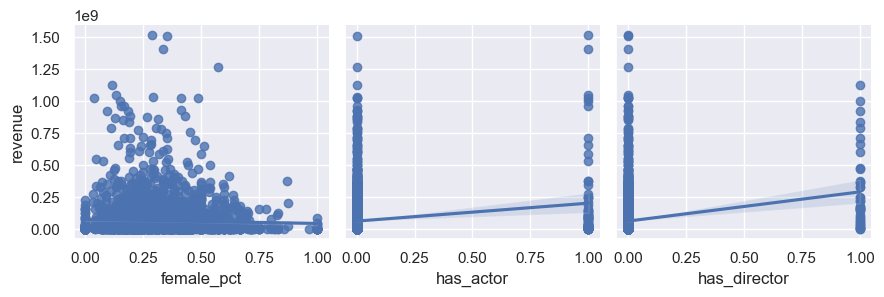

In [132]:
cols = ['female_pct', 'has_actor', 'has_director']
print('Correlation coefficients:')
for x in cols:
    print(f'{x}: {y.corr(X[x])}')
sns.pairplot(data, x_vars=cols, y_vars=['revenue'], height=3, kind='reg');

Turns out none of them are too strong predictors, but could be helpful nonetheless. <br>
Let's fit the model and see the results.

In [133]:
import statsmodels.api as sm

X = sm.add_constant(X)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     669.4
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:53:43   Log-Likelihood:                -57567.
No. Observations:                2927   AIC:                         1.151e+05
Df Residuals:                    2919   BIC:                         1.152e+05
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -2.965e+07   9.87e+06     -3.004   

We can see that is_en has a very high p-value in absolute terms as well as in comparison with the other variables, so we will eliminate it from the model and see the results.

In [134]:
X.drop(columns=['is_en'], inplace=True)
model = sm.OLS(y, X).fit()
predictions = model.predict(X)

print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                revenue   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.615
Method:                 Least Squares   F-statistic:                     780.8
Date:                Wed, 14 Jun 2023   Prob (F-statistic):               0.00
Time:                        16:53:43   Log-Likelihood:                -57567.
No. Observations:                2927   AIC:                         1.151e+05
Df Residuals:                    2920   BIC:                         1.152e+05
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
const        -3.454e+07   8.45e+06     -4.086   

The adjusted R-squared value, as well as the AIC and BIC criteria stay the same, so is_en doesn't seem to be very helpful and we can do without it. <br>
The most significant explanatory variables (based on p-values) seem to be the budget, the popularity and whether one of the popular directors is involved in the movie, followed by the female percentage of the cast and whether it casts one of the popular actors. <br>
Overall the model seems to be adequate for a rough estimate, so let's test it on a couple of movies.

In [135]:
def print_title(title):
    idx = data['title'] == title
    display(HTML(data[idx].to_html(index=False)))
    pred = model.predict(X[idx]).values[0]
    actual = y[idx].values[0]
    print(f"Predicted revenue for {title}: {pred:,.0f}")
    print(f"Actual revenue for {title}: {actual:,.0f}")
    print(f"Percent error: {abs(pred - actual) / actual * 100:.0f}%\n")

print_title('The Dark Knight')
print_title('The Godfather')

title,budget,runtime,popularity,revenue,is_en,has_actor,has_director,female_pct
The Dark Knight,185000000,152.0,123.167259,1004558444,1,1,1,0.148148


Predicted revenue for The Dark Knight: 892,843,201
Actual revenue for The Dark Knight: 1,004,558,444
Percent error: 11%



title,budget,runtime,popularity,revenue,is_en,has_actor,has_director,female_pct
The Godfather,6000000,175.0,41.109264,245066411,1,0,0,0.166667


Predicted revenue for The Godfather: 121,085,403
Actual revenue for The Godfather: 245,066,411
Percent error: 51%



It's clear that there's room for improvement, but the results are not too bad for a rather simple model.